Binned acquisition
==================

In this tutorial, we will demonstrate the sequencer-based acquisition binning procedure. The binning process is applied on the input path after real-time demodulation, (weighed) integration, IQ rotation and discretization. It allows storing both the integration and discretization
results on the fly without intervention of the host PC in up to 131072 bins. It also allows the averaging of those bins on the fly
(see section [Sequencer Acquisition](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/cluster/q1_sequence_processor.html#acquisitions)). 
We will show this by using a QRM and directly connecting outputs $\text{O}^{[1-2]}$ to inputs $\text{I}^{[1-2]}$, respectively. We will then use 
the QRM's sequencers to sequence waveforms on the outputs and, simultaneously, acquire the resulting waveforms on the inputs.

To run this tutorial please make sure you have installed and enabled ipywidgets: 
```
pip install ipywidgets
jupyter nbextension enable --py widgetsnbextension
```

Setup
-----

First, we are going to import the required packages.

In [2]:
# Import ipython widgets
import json
import math
import os

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

# Set up the environment.
import scipy.signal
import ipywidgets as widgets
#from ipywidgets import fixed, interact, interact_manual, interactive
from IPython.display import display
from qblox_instruments import Cluster, PlugAndPlay
from qcodes import Instrument
from typing import List

### Scan For Devices

We scan for the available devices connected via ethernet using the Plug & Play functionality of the Qblox Instruments package (see [Plug & Play](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/api_reference/tools.html#api-pnp) for more info).

In [3]:
# Scan for available devices and display
with PlugAndPlay() as p:
    # get info of all devices
    device_list = p.list_devices()
    
names = {
    dev_id: dev_info["description"]["name"] for dev_id, dev_info in device_list.items()
}
ip_addresses = {
    dev_id: dev_info["identity"]["ip"] for dev_id, dev_info in device_list.items()
}

# create widget for names and ip addresses
connect = widgets.Dropdown(
    options=[(names[dev_id] + " @" + ip_addresses[dev_id], dev_id) 
             for dev_id in device_list.keys()],
    description="Select Device",
)
display(connect)

Dropdown(description='Select Device', options=(('cluster-mm @10.10.200.50', '00015_2320_003'), ('cluster-mm @1…

### Connect to Cluster

We now make a connection with the Cluster selected in the dropdown widget. We also define a function to find the modules we're interested in. We select the readout and control module we want to use.

In [4]:
# Connect to device
dev_id = connect.value
# Close the chosen QCodes instrument as to prevent name clash.
try:
    Instrument.find_instrument(names[dev_id]).close()
except KeyError:
    pass

cluster = Cluster(name=names[dev_id], identifier=ip_addresses[dev_id], debug=True) # TODO remove debug

print(f"{connect.label} connected")
print(cluster.get_system_state())

C:\Users\Adithyan\anaconda3\envs\quantify-env\lib\site-packages\qcodes\instrument\instrument_base.py:472: UserWarning: Changed QAE-cluster to QAE_cluster for instrument identifier
  warnings.warn(f"Changed {name} to {new_name} for instrument identifier")


QAE-cluster @10.10.200.42 connected
Status: OKAY, Flags: NONE, Slot flags: NONE


In [5]:
def select_module_widget(device, select_all=False, select_qrm_type: bool=True, select_rf_type: bool=False):
    """Create a widget to select modules of a certain type
    
    default is to show only QRM baseband

    Args:
        devices : Cluster we are currently using
        select_all (bool): ignore filters and show all modules
        select_qrm_type (bool): filter QRM/QCM
        select_rf_type (bool): filter RF/baseband
    """
    options = [[None, None]]


    for module in device.modules:
        if module.present():
            if select_all or (module.is_qrm_type == select_qrm_type and module.is_rf_type == select_rf_type):
                options.append(
                    [
                        f"{device.name} "
                        f"{module.short_name} "
                        f"({module.module_type}{'_RF' if module.is_rf_type else ''})",
                        module,
                    ]
                )
    widget = widgets.Dropdown(options=options)
    display(widget)

    return widget

In [6]:
print("Select the readout module from the available modules:")
select_readout_module = select_module_widget(cluster, select_qrm_type=True, select_rf_type=False)

Select the readout module from the available modules:


Dropdown(options=([None, None], ['QAE_cluster module3 (QRM)', <QcmQrm: QAE_cluster_module3 of Cluster: QAE_clu…

In [7]:
readout_module = select_readout_module.value
print(f"{readout_module} connected")

<QcmQrm: QAE_cluster_module13 of Cluster: QAE_cluster> connected


### Reset the Cluster

We reset the Cluster to enter a well-defined state. Note that resetting will clear all stored parameters, so resetting between experiments is usually not desirable.

In [8]:
cluster.reset()
print(cluster.get_system_state())

Status: OKAY, Flags: NONE, Slot flags: NONE


Generate waveforms and weights<a id='gen_wf'></a>
------------------------------

Next, we need to create the waveforms used by the sequence for playback on the outputs as well as weights used by the sequence for weighed
integrations. To keep it straightforward, we use the DC offset from the sequencers as our waveform and define waveform weights in the cell
below.

In [9]:
# Waveform and weight parameters
waveform_weight_length = 600  # nanoseconds

# These will be used as weights in the "Weighed acquisition" section
waveforms_weights = {
    "gaussian": {
        "data": scipy.signal.windows.gaussian(
            waveform_weight_length, std=0.12 * waveform_weight_length
        ).tolist(),
        "index": 0,
    },
    "sine": {
        "data": [
            math.sin((2 * math.pi / waveform_weight_length) * i)
            for i in range(0, waveform_weight_length)
        ],
        "index": 1,
    },
    "block": {"data": [1.0 for _ in range(0, waveform_weight_length)], "index": 2},
}

Specify acquisitions
--------------------

We also need to specify the acquisitions so that the instrument can allocate the required memory for its acquisition list. In this case we will create 4 acquisition specifications that each create multiple bins.

In [10]:
# Acquisitions
acquisitions = {
    "non_weighed": {"num_bins": 10, "index": 0},
    "weighed": {"num_bins": 10, "index": 1},
    "large": {"num_bins": 131072, "index": 2},
    "avg": {"num_bins": 10, "index": 3},
    "single": {"num_bins": 1, "index": 4},

}

Create Q1ASM program
--------------------

Now that we have the waveform and acquisition specifications for the sequence, we need a simple Q1ASM program that sequences the waveforms and triggers the acquisitions.
In this case we will simply trigger 10 non-weighed acquisitions and store each acquisition in a separate bin.

In [11]:
# Sequence program.
seq_prog = """
      move    0,R0        #Loop iterator.
      nop

loop: acquire 0,R0,1200   #Acquire bins and store them in "non_weighed" acquisition.
      add     R0,1,R0     #Increment iterator
      nop                 #Wait a cycle for R0 to be available.
      jlt     R0,10,@loop #Run until number of iterations is done.

      stop                #Stop.
"""

Upload sequence
---------------

Now that we have the waveform, weights and acquisition specifications and Q1ASM program, we can combine them in a sequence stored in a JSON file.

In [12]:
# Add sequence program, waveforms, weights and acquisitions to single dictionary and write to JSON file.
sequence = {
    "waveforms": waveforms_weights,
    "weights": waveforms_weights,
    "acquisitions": acquisitions,
    "program": seq_prog,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

Let's write the JSON file to the instruments. We will use sequencer 0, which will drive outputs $\text{O}^{[1-2]}$ and acquire on inputs $\text{I}^{[1-2]}$.

In [13]:
# Upload sequence.
readout_module.sequencer0.sequence("sequence.json")

Play sequence
-------------

The sequence has been uploaded to the instrument. Now we need to configure the sequencers. To keep it simple we will set a DC signal on the outputs of the instrument by enabling the sequencer offsets and disabling the modulation. These DC signals will then be acquired through the inputs. As such, we will also disable the demodulation on the input path. Furthermore, since we are running non-weighed integrations, we need to specify the integration length. This integration length will be used for every non-weighed integration moving forward. We will also put the integration result acquisition rotation to 0 degrees and acquisition threshold to 0.

In [14]:
# Configure scope mode
readout_module.scope_acq_sequencer_select(0)
readout_module.scope_acq_trigger_mode_path0("sequencer")
readout_module.scope_acq_trigger_mode_path1("sequencer")

# Configure the sequencer
readout_module.sequencer0.offset_awg_path0(0.5)
readout_module.sequencer0.offset_awg_path1(0.5)
readout_module.sequencer0.mod_en_awg(False)
readout_module.sequencer0.demod_en_acq(False)
readout_module.sequencer0.integration_length_acq(1000)
readout_module.sequencer0.thresholded_acq_rotation(0)
readout_module.sequencer0.thresholded_acq_threshold(0)

# Map sequencer to specific outputs (but first disable all sequencer connections)
readout_module.disconnect_outputs()
readout_module.disconnect_inputs()

readout_module.sequencer0.connect_sequencer("io0_1")

Now let's start the sequence.

In [15]:
# Arm and start sequencer.
readout_module.arm_sequencer(0)
readout_module.start_sequencer()

# Print status of sequencer.
print(readout_module.get_sequencer_state(0, 1))

Status: STOPPED, Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE


Retrieve acquisition
--------------------

Next, we will have a quick look at the input signal so that we can compare it to the integration results. Since we are integrating over a DC signal we are expecting the integration results to be roughly equal to the average DC value.

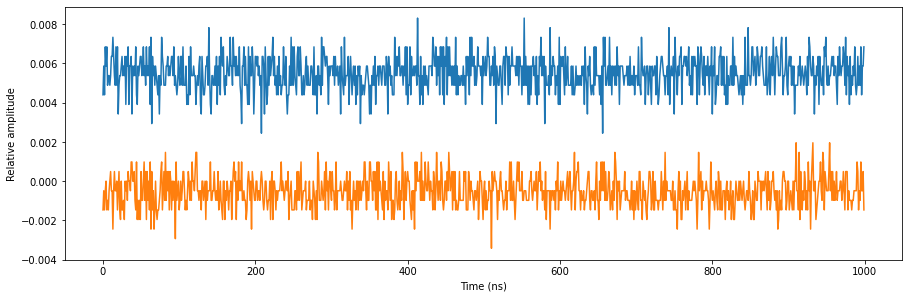

In [16]:
# Wait for the sequencer to stop with a timeout period of one minute.
readout_module.get_acquisition_state(0, 1)

# Move acquisition data from temporary memory to acquisition list.
readout_module.store_scope_acquisition(0, "non_weighed")

# Get acquisition list from instrument.
non_weighed_acq = readout_module.get_acquisitions(0)["non_weighed"]

# Plot acquired signal on both inputs.
fig, ax = plt.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))
ax.plot(non_weighed_acq["acquisition"]["scope"]["path0"]["data"][0:1000])
ax.plot(non_weighed_acq["acquisition"]["scope"]["path1"]["data"][0:1000])
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Relative amplitude")
plt.show()

To check if the integration results match what we expect, we need to divide the integration results by the integration length which was set through the 
corresponding QCoDeS parameter. Note that the 'valid' key of the dictionary indicates if the bin was actually set during the sequence.

In [12]:
int_len = readout_module.sequencer0.integration_length_acq()
bins = non_weighed_acq["acquisition"]["bins"]
bins["integration"]["path0"] = [(val / int_len) for val in bins["integration"]["path0"]]
bins["integration"]["path1"] = [(val / int_len) for val in bins["integration"]["path1"]]
bins

{'integration': {'path0': [0.27915486077186125,
   0.2791612115290669,
   0.27915192965315094,
   0.27901367855398146,
   0.2791001465559355,
   0.2791299462628236,
   0.2789799706888129,
   0.2790600879335613,
   0.279057156814851,
   0.27897557401074746],
  'path1': [0.2676213971665853,
   0.26770151441133366,
   0.2676560820713239,
   0.26742061553492913,
   0.2675017098192477,
   0.26750122129946263,
   0.2674181729360039,
   0.26754714215925746,
   0.26734391792867607,
   0.26737909135319976]},
 'threshold': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'avg_cnt': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Weighed acquisition
-------------------

In the following, we look into weighed integrations. To do this, we will need to modify the sequence program slightly and reupload it. We will be using a gaussian weight to integrate over input path 0 and a sine weight to integrate over input path 1. The integration length of a weighed integration is determined by the weight length. 

In [13]:
# Sequence program.
seq_prog = """
      move            0,R0            #Loop iterator.
      move            0,R1            #Weight for path 0.
      move            1,R2            #Weight for path 1.
      nop

loop: acquire_weighed 1,R0,R1,R2,1200 #Acquire bins and store them in "weighed" acquisition.
      add             R0,1,R0         #Increment iterator
      nop                             #Wait a cycle for R0 to be available.
      jlt             R0,10,@loop     #Run until number of iterations is done.

      stop                            #Stop.
"""

In [14]:
# Add sequence program, waveforms, weights and acquisitions to single dictionary and write to JSON file.
sequence = {
    "waveforms": waveforms_weights,
    "weights": waveforms_weights,
    "acquisitions": acquisitions,
    "program": seq_prog,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

In [15]:
# Upload sequence.
readout_module.sequencer0.sequence("sequence.json")

Let's start the sequence and retrieve the results.

In [16]:
# Arm and start sequencer.
readout_module.arm_sequencer(0)
readout_module.start_sequencer()

# Print status of sequencer.
print(readout_module.get_sequencer_state(0, 1))

Status:
Status: STOPPED, Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE


In [17]:
# Wait for the sequencer to stop with a timeout period of one minute.
readout_module.get_acquisition_state(0, 1)

# Get acquisition list from instrument.
weighed_acq = readout_module.get_acquisitions(0)["weighed"]

To check if the integration results match what we expect we need to divide the integration results by the integration length again. In this case the integration
length is determined by the length of the weights.

In [18]:
int_len = waveform_weight_length
bins = weighed_acq["acquisition"]["bins"]
bins["integration"]["path0"] = [(val / int_len) for val in bins["integration"]["path0"]]
bins["integration"]["path1"] = [(val / int_len) for val in bins["integration"]["path1"]]
bins

{'integration': {'path0': [0.0838375615631583,
   0.08379245402794945,
   0.0838248975170451,
   0.08380893490833831,
   0.08373342157077765,
   0.0837548154917014,
   0.08381608371642879,
   0.08383202245997753,
   0.08376547844431308,
   0.08379022621544653],
  'path1': [-5.6059653985437636e-05,
   -3.018027660831874e-05,
   3.383960084091271e-05,
   6.327051148681764e-06,
   -1.1236511909867344e-06,
   1.715626436135604e-05,
   -0.00011699814177924457,
   -5.624102918653143e-05,
   -3.3345592069512524e-05,
   -0.00010118747457863478]},
 'threshold': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'avg_cnt': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Large number of bins
--------------------

The QRM supports up to 131072 bins. To show that we need to change the program slightly. We will use the non-weighed acquisition program,
however, we will now loop over the maximum number of acquisitions while storing each result in a separate bin.

In [19]:
# Sequence program.
seq_prog = """
      move    0,R0            #Loop iterator.
      nop

loop: acquire 2,R0,1200       #Acquire bins and store them in "large" acquisition.
      add     R0,1,R0         #Increment iterator
      nop                     #Wait a cycle for R0 to be available.
      jlt     R0,131072,@loop #Run until number of iterations is done.

      stop                    #Stop.
"""

In [20]:
# Add sequence program, waveforms, weights and acquisitions to single dictionary and write to JSON file.
sequence = {
    "waveforms": waveforms_weights,
    "weights": waveforms_weights,
    "acquisitions": acquisitions,
    "program": seq_prog,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

In [21]:
# Upload sequence.
readout_module.sequencer0.sequence("sequence.json")

Let's start the sequence and retrieve the results.

In [22]:
# Arm and start sequencer.
readout_module.arm_sequencer(0)
readout_module.start_sequencer()

# Print status of sequencer.
print(readout_module.get_sequencer_state(0, 1))

Status:
Status: STOPPED, Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE


In [23]:
# Wait for the sequencer to stop with a timeout period of one minute.
readout_module.get_acquisition_state(0, 1)

# Get acquisition list from instrument.
large_acq = readout_module.get_acquisitions(0)["large"]

Since the number of bins is now to large to simply print, we will check the number of bins and we will check the bins for NaN values which indicate that a bin is not written. 

In [24]:
int_len = readout_module.sequencer0.integration_length_acq()
bins = large_acq["acquisition"]["bins"]
bins["integration"]["path0"] = [(val / int_len) for val in bins["integration"]["path0"]]
bins["integration"]["path1"] = [(val / int_len) for val in bins["integration"]["path1"]]

print("Number of bins: {}".format(len(bins["avg_cnt"])))
for it, val in enumerate(bins["integration"]["path0"]):
    if math.isnan(val):
        raise Exception("NaN found at index {}.".format(it))
for it, val in enumerate(bins["integration"]["path1"]):
    if math.isnan(val):
        raise Exception("NaN found at index {}.".format(it))
print('All values are valid.')

Number of bins: 131072
All values are valid.


We will also plot the integration results in every bin to visualize the contents.

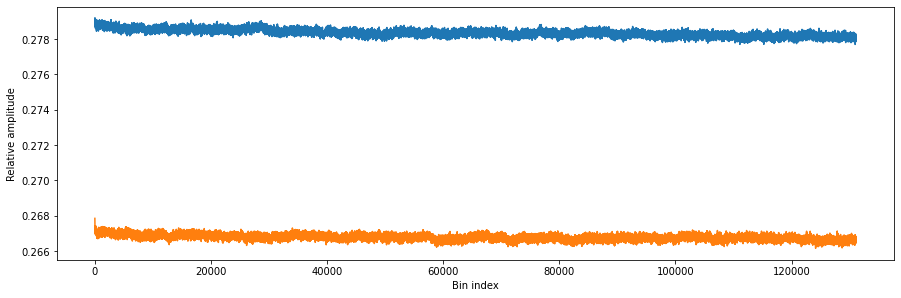

In [25]:
# Plot bins
fig, ax = plt.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))
ax.plot(bins["integration"]["path0"])
ax.plot(bins["integration"]["path1"])
ax.set_xlabel("Bin index")
ax.set_ylabel("Relative amplitude")
plt.show()

Averaging
--------------------

As you may have noticed, the acquisition results also contain an average counter. This average counter reflects the number of times a bin has been averaged during the sequence.
Each time the sequencer writes to the same bin the results are automatically accumulated and the average counter is increased. Upon retrieval of the acquisition results, each
result is divided by the average counter and therefore automatically averaged. To show this we will change the sequence one last time. This time we will average 10 bins a 1000
times each.

In [26]:
# Sequence program.
seq_prog = """
      move    0,R1         #Average iterator.

avg:  move    0,R0         #Bin iterator.
      nop

loop: acquire 3,R0,1200    #Acquire bins and store them in "avg" acquisition.
      add     R0,1,R0      #Increment bin iterator
      nop                  #Wait a cycle for R0 to be available.
      jlt     R0,10,@loop  #Run until number of avg iterations is done.
      add     R1,1,R1      #Increment avg iterator
      nop                  #Wait a cycle for R1 to be available.
      jlt     R1,1000,@avg #Run until number of average iterations is done.

      stop                 #Stop.
"""

In [27]:
# Add sequence program, waveforms, weights and acquisitions to single dictionary and write to JSON file.
sequence = {
    "waveforms": waveforms_weights,
    "weights": waveforms_weights,
    "acquisitions": acquisitions,
    "program": seq_prog,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

In [28]:
# Upload sequence.
readout_module.sequencer0.sequence("sequence.json")

Let's start the sequence and retrieve the results.

In [29]:
# Arm and start sequencer.
readout_module.arm_sequencer(0)
readout_module.start_sequencer()

# Print status of sequencer.
print(readout_module.get_sequencer_state(0, 1))

Status:
Status: STOPPED, Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE


Note that the average count of each bin is now set to a 1000.

In [30]:
# Wait for the sequencer to stop with a timeout period of one minute.
readout_module.get_acquisition_state(0, 1)

# Get acquisition list from instrument.
avg_acq = readout_module.get_acquisitions(0)["avg"]

In [31]:
int_len = readout_module.sequencer0.integration_length_acq()
bins = avg_acq["acquisition"]["bins"]
bins["integration"]["path0"] = [(val / int_len) for val in bins["integration"]["path0"]]
bins["integration"]["path1"] = [(val / int_len) for val in bins["integration"]["path1"]]
bins

{'integration': {'path0': [0.2783555486077186,
   0.2783564631167562,
   0.2783504118221788,
   0.2783517176355642,
   0.27834840449438203,
   0.27835067464582314,
   0.2783542623351246,
   0.2783474118221788,
   0.2783547987298486,
   0.2783543351245726],
  'path1': [0.26682932535417686,
   0.2668245642403517,
   0.26682411724474836,
   0.2668218031265267,
   0.2668268925256473,
   0.26682839179286766,
   0.2668272222765022,
   0.2668283277967758,
   0.2668281695163654,
   0.2668296311675623]},
 'threshold': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'avg_cnt': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]}

Characterizing Input Offset
=============================

The Qblox QRM and QRM-RF use analog-to-digital converters (ADCs) to digitize the incoming analog signals. Due to thermal, manufacturing effects or other factors, the digitized signal is not centered around 0V but has a small offset, which we will hereby refer to as input (ADC) offset. This input offset can get demodulated and integrated by the hardware along with the signal. The integrated offset can then show up as oscillations in the result, e.g. during a frequency sweep. In this section we show how to measure and calibrate away this offset to prevent such effects.

Measuring the Offset
--------------------


We will use a simple scope acquisition to determine the mean value of this offset. Before proceeding, please **make sure that there is no DC signal going into** to your QRM. 

In [45]:
cluster.reset()

In [46]:
def acquire_scope_and_calc_offsets():
    seq_prog = """
    acquire 4,0,16380 #Acquire waveforms and wait remaining duration of scope acquisition. 
    stop              #Stop.
    """

    # Add sequence program, waveforms, weights and acquisitions to single dictionary and write to JSON file.
    sequence = {
        "waveforms": {},
        "weights": {},
        "acquisitions": acquisitions,
        "program": seq_prog,
    }
    with open("sequence.json", "w", encoding="utf-8") as file:
        json.dump(sequence, file, indent=4)
        file.close()

    # Upload sequence.
    readout_module.sequencer0.sequence("sequence.json")


    # Arm and start sequencer.
    readout_module.arm_sequencer(0)
    readout_module.start_sequencer()

    # Wait for the acquisition to stop
    readout_module.get_acquisition_state(0, 1)

    # Retrieve results
    readout_module.store_scope_acquisition(0, "single")
    single_acq = readout_module.get_acquisitions(0)
    I = numpy.array(single_acq["single"]["acquisition"]["scope"]["path0"]["data"])
    Q = numpy.array(single_acq["single"]["acquisition"]["scope"]["path1"]["data"])

    # Plot results
    fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))
    ax.plot(I, label = "I")
    ax.plot(Q, label = "Q")
    ax.set_xlabel("Time (ns)", fontsize = 20)
    ax.set_ylabel("Relative amplitude", fontsize = 20)
    matplotlib.pyplot.legend()
    matplotlib.pyplot.show()

    # Print mean offset values
    I_offset, Q_offset = numpy.mean(I), numpy.mean(Q)
    print(f"I Offset : {I_offset*1e3:.3f} mV \nQ Offset : {Q_offset*1e3:.3f} mV")
    
    return I_offset, Q_offset

In [47]:
readout_module.scope_acq_sequencer_select(0)
readout_module.scope_acq_trigger_mode_path0("sequencer")
readout_module.scope_acq_trigger_mode_path1("sequencer")

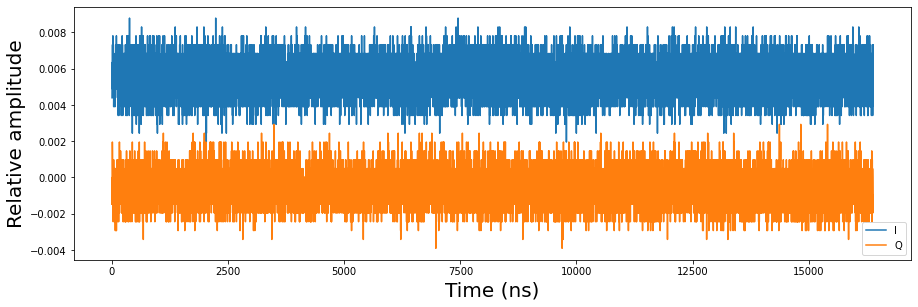

I Offset : 5.535 mV 
Q Offset : -0.598 mV


In [48]:
I_offset,Q_offset = acquire_scope_and_calc_offsets()

Correcting the Offsets
-------------------------

One can correct for these offsets by changing the reference Voltage of the ADC. This can be done using the parameters <code>[QRM.in0_offset](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/api_reference/qcm_qrm.html#QRM.in0_offset)</code> and <code>[QRM.in1_offset](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/api_reference/qcm_qrm.html#QRM.in1_offset)</code> for the baseband modules and <code>[QRM.in0_offset_path0](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/api_reference/qcm_qrm.html#QRM.in0_offset_path0)</code> and <code>[QRM.in0_offset_path1](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/api_reference/qcm_qrm.html#QRM_RF.in0_offset_path1)</code> for the QRM-RF.


In [ ]:
readout_module.in0_offset(-I_offset) # Negative sign to compensate for the offset
readout_module.in1_offset(-Q_offset)

Repeating the offset measurement as before, we get: 

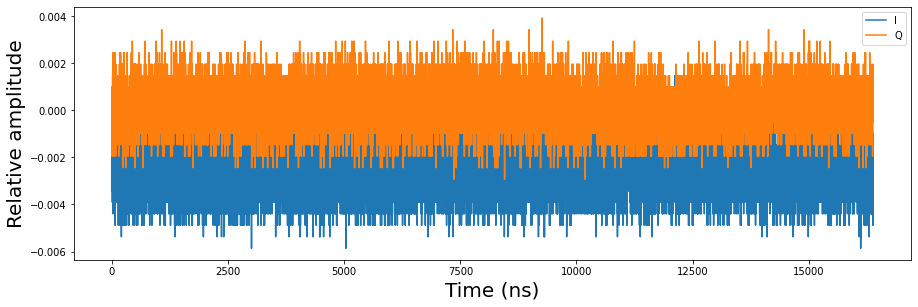

I Offset : -2.680 mV 
Q Offset : 0.139 mV


In [50]:
I_offset, Q_offset = acquire_scope_and_calc_offsets()

Advanced ADC Offset Calibration : Curve Fitting Method
----------------------------------------------------

As you may have noticed in the previous section, manually compensating for the offset does not entirely eliminate it, leaving some residual offset. This is because of the non-linear effects of these input offsets. To circumvent this, one can curve-fit the dependence of the set offset value on the actual offset value. In the following section, we do this by fitting 10 setpoints against the 10 measured offset values from the binned acquisition with a function. We then find the roots/zeros of this function to set the actual offset to zero. 

In [75]:
# Define helper functions
def get_real_root(coeffs) : 
    for root in numpy.roots(coeffs) :
        if root.imag == 0 :
            output = root
    return numpy.real(output)

def get_curve(x,coeffs) :
    y = 0 
    for i,coeff in enumerate (coeffs)  : 
        y += coeff*x**(len(coeffs)-(i+1))    
    return y


In [76]:
seq_prog = """
      move    0,R0        #Loop iterator.
      nop

loop: acquire 0,R0,16000   #Acquire bins and store them in "non_weighed" acquisition.
      add     R0,1,R0     #Increment iterator
      nop                 #Wait a cycle for R0 to be available.
      jlt     R0,100,@loop #Run until number of iterations is done.

      stop                #Stop.
"""

In [77]:
# Add sequence program, waveforms, weights and acquisitions to single dictionary and write to JSON file.
sequence = {
    "waveforms": {},
    "weights": {},
    "acquisitions": acquisitions,
    "program": seq_prog,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

In [78]:
# Upload sequence.
readout_module.sequencer0.sequence("sequence.json")

Let's start the sequence and retrieve the results.

In [79]:
# Start out by setting the original offset values obtained from inspecting the scope
readout_module.in0_offset(- numpy.sign(I_offset)*I_offset)
readout_module.in1_offset(- numpy.sign(Q_offset)*Q_offset)

# Set the domain (X) around these original offset values
I_offset_setpoints = numpy.linspace(-10e-3+ readout_module.in0_offset(),+10e-3 + readout_module.in0_offset(),12)
Q_offset_setpoints = numpy.linspace(-10e-3+ readout_module.in1_offset(),+10e-3 + readout_module.in1_offset(),12)

int_len = readout_module.sequencer0.integration_length_acq()
I_offset_sum, Q_offset_sum = [],[]   

for I_offset_i, Q_offset_i in zip(I_offset_setpoints, Q_offset_setpoints) :
    readout_module.delete_acquisition_data(0,all=True)
    readout_module.in0_offset(I_offset_i)
    readout_module.in1_offset(Q_offset_i)
    readout_module.arm_sequencer(0)
    readout_module.start_sequencer()
    readout_module.get_acquisition_state(0, 1)
    non_weighed_acq = readout_module.get_acquisitions(0)["non_weighed"]
    I_offset_sum += [numpy.mean(non_weighed_acq["acquisition"]["bins"]["integration"]["path0"])*1e3/int_len]
    Q_offset_sum += [numpy.mean(non_weighed_acq["acquisition"]["bins"]["integration"]["path1"])*1e3/int_len]


output = {'offsets_I' : I_offset_setpoints, 'offsets_Q' : Q_offset_setpoints ,'I_m' : I_offset_sum , 'Q_m' : Q_offset_sum }

Offset setpoints corresponding to observed zero offset: 
I offset: -3.652540800235728
Q offset: 0.6395817994481054


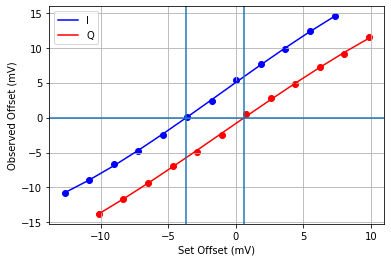

In [91]:
matplotlib.pyplot.figure()

## Fit I offset and find its root
coeffs = numpy.polyfit(numpy.array(output['offsets_I'])*1e3,numpy.array(output['I_m']),3)
new_I_offset = get_real_root(coeffs)

matplotlib.pyplot.plot(output['offsets_I']*1e3,get_curve(numpy.array(output['offsets_I'])*1e3,coeffs),c='b', label="I")
matplotlib.pyplot.scatter(output['offsets_I']*1e3,output['I_m'],c='b')

# Fit Q offset and find its root
coeffs = numpy.polyfit(numpy.array(output['offsets_Q'])*1e3,numpy.array(output['Q_m']),3)
new_Q_offset = get_real_root(coeffs)

matplotlib.pyplot.plot(output['offsets_Q']*1e3,get_curve(numpy.array(output['offsets_Q'])*1e3,coeffs),c='r', label="Q")
matplotlib.pyplot.scatter(output['offsets_Q']*1e3,output['Q_m'],c='r')

# Plot zeros on the plot
matplotlib.pyplot.axvline(x=new_I_offset)
matplotlib.pyplot.axvline(x=new_Q_offset)
matplotlib.pyplot.axhline(y=0)

matplotlib.pyplot.xlabel('Set Offset (mV)')
matplotlib.pyplot.ylabel('Observed Offset (mV)')
matplotlib.pyplot.legend()
matplotlib.pyplot.grid()
print(f"Offset setpoints corresponding to observed zero offset: \nI offset: {new_I_offset}\nQ offset: {new_Q_offset}")

Applying The Offset Corrections
-----------

Using the zeros obtained from the curve fitting, we attempt to correct for the input offsets again:

In [81]:
readout_module.in0_offset(new_I_offset*1e-3) # Multiplying by 1e-3 to convert to mV 
readout_module.in1_offset(new_Q_offset*1e-3)

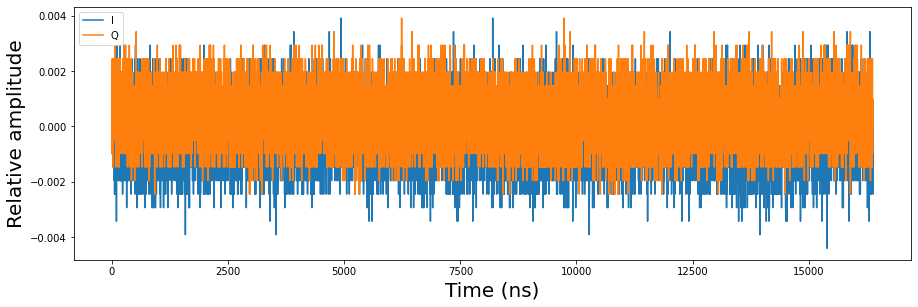

I Offset : -0.034 mV 
Q Offset : 0.355 mV


In [82]:
I_offset_calib, Q_offset_calib = acquire_scope_and_calc_offsets() 

As you can see, you have calibrated away the offsets to sub-millivolt range, which is at the limit of the ADC resolution. 

<div class="alert alert-success">
We advise you to check/calibrate these offset values every few days if they are vital for your experiments, especially when you are dealing with low input signals. </div>

Stop
----

Finally, let's stop the sequencers if they haven't already and close the instrument connection. One can also display a detailed snapshot containing the instrument parameters before 
closing the connection by uncommenting the corresponding lines. 

In [ ]:
# Stop sequencer.
readout_module.stop_sequencer()

# Print status of sequencer.
print(readout_module.get_sequencer_state(0))
print()

# Uncomment the following to print an overview of the instrument parameters.
# Print an overview of the instrument parameters.
# print("Snapshot:")
# readout_module.print_readable_snapshot(update=True)

# Close all QCoDeS Instrument instances.
Instrument.close_all()